# Coursework C

PCA and MNIST

In [33]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import matplotlib.style
import matplotlib as mpl

from scipy import linalg

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=150

#Useful for debugging problems
print(tf.__version__)

2.10.1


In [34]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(x_train_og, y_train), (x_test_og, y_test) = mnist.load_data()

1. Train a neural network on the MNIST training dataset that achieves acceptable performance on the test dataset (>95% accuracy)

In [35]:
# Preprocess the data

# Normalize the pixel values to be between 0 and 1
x_train = x_train_og / 255
x_test = x_test_og / 255

# Reshape for CNN input as CNNs process images as 3D tensors (height, width, channels), greyscale so 1 channel
x_train = x_train.reshape((-1, 28, 28, 1)) # -1 at front to add channel dimension
x_test = x_test.reshape((-1, 28, 28, 1))

# Build the model
def buildModel():
    """
    Builds a convolutional neural network model for image classification.

    Returns:
    keras.models.Sequential: The compiled neural network model
    """
    # Define the model
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Train the model
base_model = buildModel()
base_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
_, test_acc = base_model.evaluate(x_test, y_test) # "_" is used to ignore the loss value
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/5
844/844 [==============================] - 32s 38ms/step - loss: 0.1915 - accuracy: 0.9415 - val_loss: 0.0636 - val_accuracy: 0.9830
Epoch 2/5
844/844 [==============================] - 32s 38ms/step - loss: 0.0569 - accuracy: 0.9827 - val_loss: 0.0504 - val_accuracy: 0.9870
Epoch 3/5
844/844 [==============================] - 32s 38ms/step - loss: 0.0407 - accuracy: 0.9871 - val_loss: 0.0481 - val_accuracy: 0.9853
Epoch 4/5
844/844 [==============================] - 38s 45ms/step - loss: 0.0291 - accuracy: 0.9906 - val_loss: 0.0363 - val_accuracy: 0.9897
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.0298 - accuracy: 0.9898
Test Accuracy: 0.9898


2. Decompose the MNIST training dataset into its PCA components

In [36]:
# Reshape training images for PCA (flatten)
X_train = np.reshape(x_train_og, (60000, 784))

# Center the data
mu = np.mean(X_train, axis=0)
x = X_train - mu

# Calculate the covariance matrix
rho = np.cov(x, rowvar=False)

# Get the eigenvalues and vectors
vals, vecs = linalg.eigh(rho)
vecs = np.flip(vecs, axis=1)  # Flip along columns, so that eigenvalues and eigenvectors are in descending order
vals = np.flip(vals)

#fig,ax=plt.subplots()
#ax.imshow(np.reshape(vecs[:,0],[28,28]), origin='lower',cmap='binary',interpolation='nearest')

3. Use the N-best PCA components to make a new testing dataset (using the 10,000 MNIST test images) and make a plot of N vs testing accuracy using the neural network trained in 1) without retraining the network

N=1, Test Accuracy: 0.1056
N=5, Test Accuracy: 0.2593
N=10, Test Accuracy: 0.3751
N=50, Test Accuracy: 0.5955
N=100, Test Accuracy: 0.6387
N=200, Test Accuracy: 0.6563
N=500, Test Accuracy: 0.9815
N=784, Test Accuracy: 0.9852


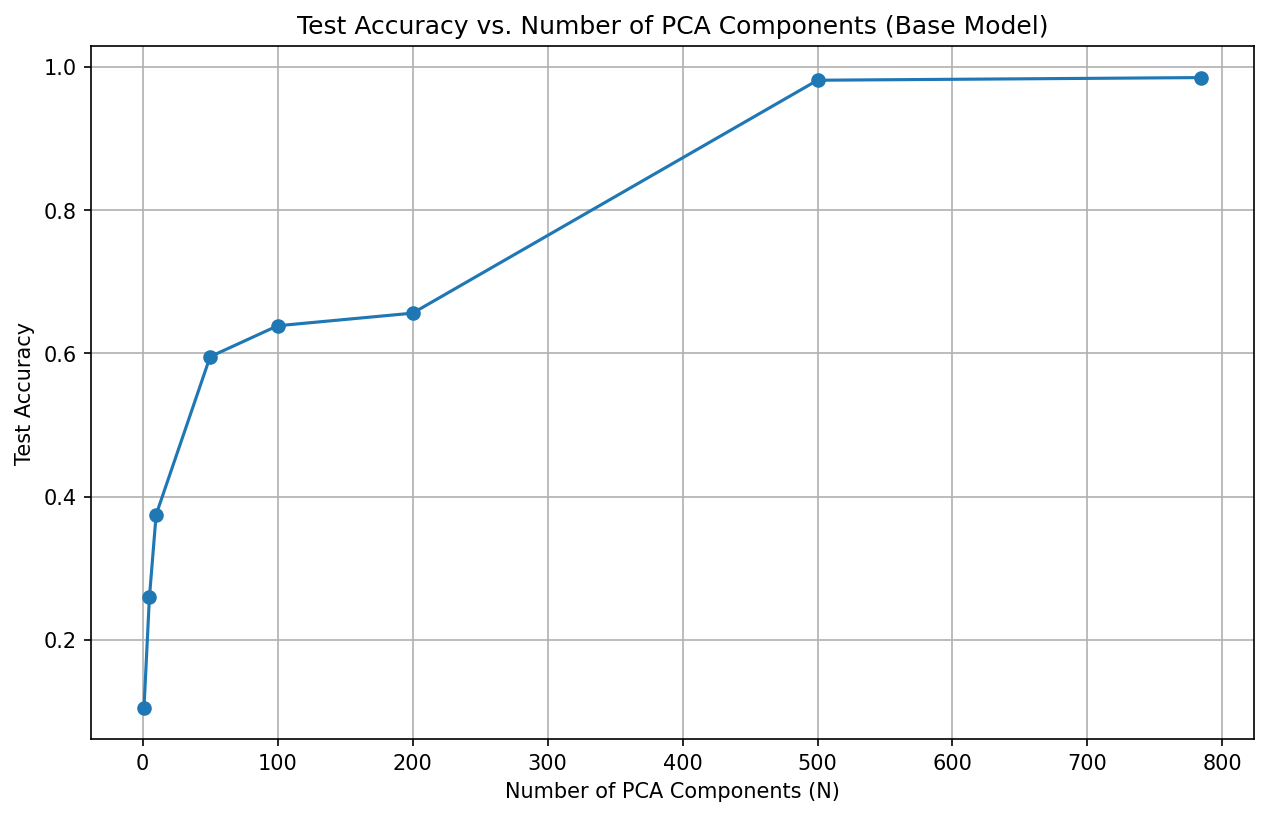

In [37]:
def test_with_pca(model, eigenvectors, eigenvalues, n_components, x_test_original, y_test_original, train_mean):
    """Tests a model with data projected onto the top N PCA components.

    Args:
        model: The trained Keras model
        eigenvectors: The eigenvectors from PCA
        eigenvalues: The eigenvalues from PCA
        n_components: The number of PCA components to use
        x_test_original: The original test images
        y_test_original: The original test labels
        train_mean:  The mean of the training data

    Returns:
        float: The test accuracy
    """
    # Reshape the test images for PCA (flatten)
    X_test = np.reshape(x_test_original, (-1, 784))

    # Center the test data using the training data's mean
    X_test_centered = X_test - train_mean

    # Project the test data onto the top N eigenvectors (descending order so slice the first n_components)
    X_test_reduced = np.dot(X_test_centered, eigenvectors[:, :n_components])

    # Reconstruct the test data
    X_test_reconstructed = np.dot(X_test_reduced, eigenvectors[:, :n_components].T) + train_mean

    # Reshape back to CNN input shape (28x28x1)
    X_test_reconstructed_cnn = X_test_reconstructed.reshape(-1, 28, 28, 1)

    # Normalise the reconstructed data
    X_test_reconstructed_cnn = np.clip(X_test_reconstructed_cnn, 0, 1)

    # Evaluate the model
    _, test_acc = model.evaluate(X_test_reconstructed_cnn, y_test_original, verbose=0)
    return test_acc

#  Range of N values to test
n_components_range = [1, 5, 10, 50, 100, 200, 500, 784]
accuracies = []

for n in n_components_range:
    acc = test_with_pca(base_model, vecs, vals, n, x_test_og, y_test, mu)
    accuracies.append(acc)
    print(f"N={n}, Test Accuracy: {acc:.4f}")

# Plot N vs. Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, accuracies, marker='o')
plt.xlabel('Number of PCA Components (N)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Number of PCA Components (Base Model)')
plt.grid(True)
plt.show()

4. Now using the 100-best PCA components make a new training dataset (using the 60,000 MNIST training images) and retrain your neural network from 1)
5. Repeat step 3 using your new neural network from 4)

N=1, Test Accuracy: 0.1161
N=5, Test Accuracy: 0.2898
N=10, Test Accuracy: 0.4956
N=50, Test Accuracy: 0.9536
N=100, Test Accuracy: 0.9816
N=200, Test Accuracy: 0.9747
N=500, Test Accuracy: 0.9313
N=784, Test Accuracy: 0.9315


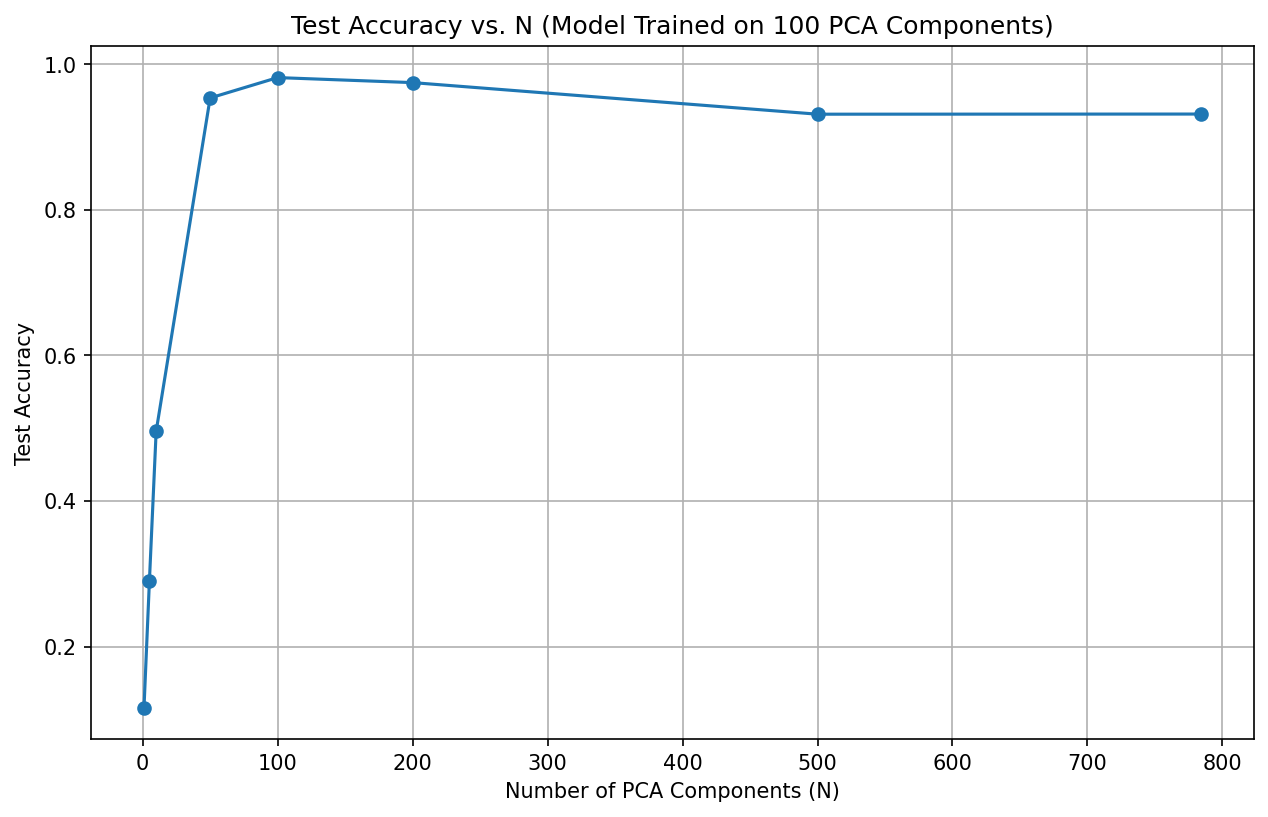

In [ ]:
def train_and_evaluate_pca(n_train_components, n_test_components_range, x_train_original, y_train_original, x_test_original, y_test_original):
    
    # PCA on training data
    X_train = np.reshape(x_train_original, (len(x_train_original),784))
    mu_train = np.mean(X_train, axis=0)
    x_train = X_train - mu_train
    rho_train = np.cov(x_train, rowvar=False)
    vals_train, vecs_train = linalg.eigh(rho_train)
    vecs_train = np.flip(vecs_train, axis = 1)
    vals_train = np.flip(vals_train)

    X_train_reduced = np.dot(x_train, vecs_train[:, :n_train_components])
    X_train_reconstructed = np.dot(X_train_reduced, vecs_train[:, :n_train_components].T) + mu_train
    X_train_reconstructed_cnn = X_train_reconstructed.reshape(-1, 28, 28, 1)
    X_train_reconstructed_cnn = np.clip(X_train_reconstructed_cnn, 0, 1)

    # Train new model
    new_model = buildModel()
    new_model.fit(X_train_reconstructed_cnn, y_train_original, epochs=5, batch_size=64, validation_split=0.1, verbose=0)

    # Test with varying PCA components
    accuracies_new = []
    for n_test in n_test_components_range:
        acc = test_with_pca(new_model, vecs_train, vals_train, n_test, x_test_original, y_test_original, mu_train)
        accuracies_new.append(acc)
        print(f"N={n_test}, Test Accuracy: {acc:.4f}")

    return new_model, accuracies_new, n_test_components_range

# Train and evaluate with 100 components
model_100, accuracies_100, n_components_range_100 = train_and_evaluate_pca(100, n_components_range, x_train_og, y_train, x_test_og, y_test)

# Plot for 100-component model
plt.figure(figsize=(10, 6))
plt.plot(n_components_range_100, accuracies_100, marker='o')
plt.xlabel('Number of PCA Components (N)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. N (Model Trained on 100 PCA Components)')
plt.grid(True)
plt.show()

6. Finally repeat steps 4 and 5 using a network trained with the best 20 components

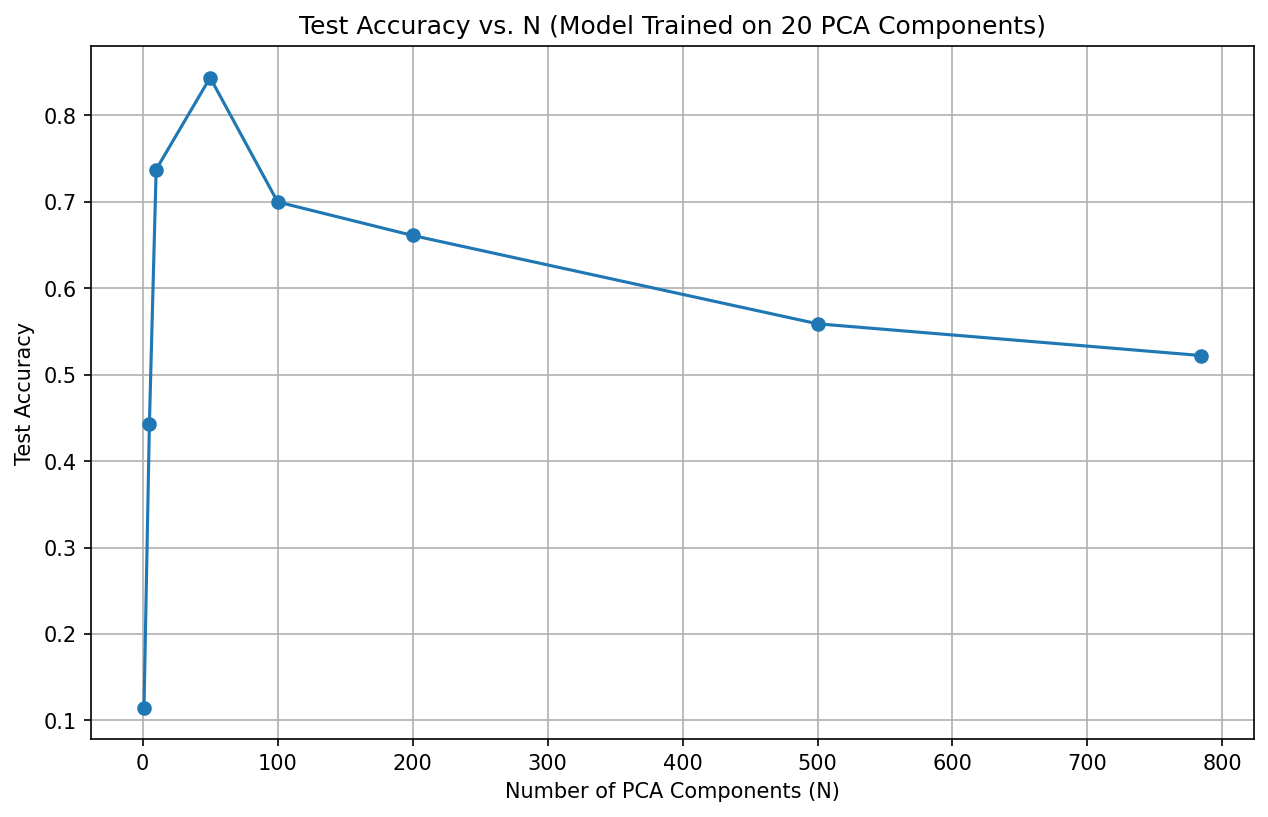

In [32]:
# Train and evaluate with 20 components
model_20, accuracies_20, n_components_range_20 = train_and_evaluate_pca(20, n_components_range,  x_train_og, y_train, x_test_og, y_test)

# Plot for 20-component model
plt.figure(figsize=(10, 6))
plt.plot(n_components_range_20, accuracies_20, marker='o')
plt.xlabel('Number of PCA Components (N)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. N (Model Trained on 20 PCA Components)')
plt.grid(True)
plt.show()